# Plot the angular correlation function using the output from Angular_Correlation_Stable.py
### Here we plot:
### -- The correlation function
### -- The regression matrix
### -- bias vs. z



In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from scipy.optimize import curve_fit

In [2]:
#Generate the covariance matrix from the Jackknife file
def make_covariance(Jackfile, warray, RRarray):
    JK_xi = []
    size = float(len(warray))
    jkdat = open(Jackfile,'rw')
    #Read the header of the jackknife file and assign the number of jackknife resamples done for the sample
    jkhead = jkdat.readline()
    print jkhead
    jknum= np.float(jkhead.split()[7])
    #Pull out the proper info from the file (RR,Xi,etc.) for each jackknife and put into array
    RRjk = np.zeros([int(jknum),int(size)])
    Xijk = np.zeros([int(jknum),int(size)])
    Thjk = np.zeros([int(jknum),int(size)])
    
    num=jkdat.readlines()
    row = 0
    k=0

    for j in range(len(num)):
        #At the end of a Jackknife run, I create a new line called 'STEP_DONE' which tells me that my next JK routine is running and separates the two.
        if num[j].split()[0] == 'STEP_DONE':
            row +=1
            k=0
        #For each of the JK runs, append the info into arrays
        else:
            Thjk[row,k] = float(num[j].split()[0])
            RRjk[row,k] = float(num[j].split()[3])
            Xijk[row,k] = float(num[j].split()[4])
            k+=1
    C = np.zeros([len(RRjk[0]),len(RRjk[0])])
    for m in range(len(RRjk[0])):
        for n in range(len(RRjk[0])):
            left = np.sqrt(np.asarray(RRjk[:,m])/RRarray[m])
            dwa = np.asarray(Xijk[:,m]) - warray[m]
            right = np.sqrt(np.asarray(RRjk[:,n])/RRarray[n])
            dwb = np.asarray(Xijk[:,n]) - warray[n]
            val = left*dwa*right*dwb
            C[m,n] = sum(val)
    return C

#Generate the covariance matrix from the Jackknife file
def make_JKxi(Jackfile, warray, RRarray):
    JK_xi = []
    size = float(len(warray))
    jkdat = open(Jackfile,'rw')
    #Read the header of the jackknife file and assign the number of jackknife resamples done for the sample
    jkhead = jkdat.readline()
    jknum= np.float(jkhead.split()[7])
    #Pull out the proper info from the file (RR,Xi,etc.) for each jackknife and put into array
    RRjk = np.zeros([int(jknum),int(size)])
    Xijk = np.zeros([int(jknum),int(size)])
    Thjk = np.zeros([int(jknum),int(size)])
    
    num=jkdat.readlines()
    row = 0
    k=0

    for j in range(len(num)):
        #At the end of a Jackknife run, I create a new line called 'STEP_DONE' which tells me that my next JK routine is running and separates the two.
        if num[j].split()[0] == 'STEP_DONE':
            row +=1
            k=0
        #For each of the JK runs, append the info into arrays
        else:
            Thjk[row,k] = float(num[j].split()[0])
            RRjk[row,k] = float(num[j].split()[3])
            Xijk[row,k] = float(num[j].split()[4])
            k+=1
    JK_xi.append(Xijk)   
    return JK_xi

#Compute chi square
def chisq(dat,mod,cmat):
    x = 0
    inverse = np.linalg.inv(cmat)
    for i in range(len(cmat)):
        for j in range(len(cmat)):
            df1 = dat[i]-mod[i]
            df2 = dat[j]-mod[j]
            #icv = cmat[i,j]**-1
            icv = inverse[i,j]
            x += df1*icv*df2
    return x

#Compute the regression matrix
def Regressmat(covar,theta):
    R= np.zeros([len(theta),len(theta)])
    for i in range(len(theta)):
        for j in range(len(theta)):
            R[i,j] = covar[i,j]/(np.sqrt(covar[i,i])*np.sqrt(covar[j,j]))
    return R

## Open The files here 

In [36]:
### SPLITTING BY Z Cuting at any imag
allz= '../Compute_correlation/New_clustering_noVCV.txt'
#allz = '../Compute_correlation/Final_Angcor_Result_deccut.txt'
lowz = '../Compute_correlation/New_clustering_noVCV_faint_only.txt'
#highz = '../Compute_correlation/Final_Angcor_Result_deccut_highz.txt'

allzJK = '../Compute_correlation/New_clustering_noVCV_JK.txt'
#allzJK = '../Compute_correlation/Final_Angcor_Result_deccut_JK.txt'
lowzJK = '../Compute_correlation/New_clustering_noVCV_faint_only_JK.txt'
#highzJK = '../Compute_correlation/Final_Angcor_Result_deccut_highz_JK.txt'

datfiles = [allz,lowz]#,highz]
JKfiles = [allzJK,lowzJK]#,highzJK]


## Pull out the relevant information (theta, correlation function, RR array)

In [37]:
#Loop over the data files list to open and plot the correlation function
separation = []
wnames = []
RRnames = []
DDnames = []
DRnames = []
for infile in datfiles:
    fileopen = open(infile,'rw')
    header = fileopen.readline()
    data = fileopen.readlines() 

    th = []
    w = []
    RR = []
    DD = []
    DR = []
    for i in range(len(data)):
        t = float(data[i].split()[0]) #Theta
        x = float(data[i].split()[4]) #w(theta) 
        rr = float(data[i].split()[3]) #RR 
        dd = float(data[i].split()[1]) #DD
        dr = float(data[i].split()[2]) #DR 
        w.append(x)
        RR.append(rr)
        DD.append(dd)
        DR.append(dr)
        th.append(t)
    #Put the w and RR values into an array to call for Jackknife calculation
    wnames.append(w)
    RRnames.append(RR)
    DDnames.append(DD)
    DRnames.append(DR)
    separation.append(th)

## Run the JK error routine to make the covariance matrix for each input file
## Compute the regression matrix from the covariance

In [38]:
#Compute Jackknife errors from the counts information
sigma = []
covmat = []
for h in range(len(JKfiles)):
    covariance = make_covariance(JKfiles[h], wnames[h], RRnames[h])
    sigma.append(np.diag(covariance))
    covmat.append(covariance)

#Compute the regression matrix
regmat = []
for h in range(len(wnames)):
    regmat.append(Regressmat(covmat[h],th))

print np.shape(JKfiles)

#Theta DD DR RR XI factor=161.359185919 jknum= 20

#Theta DD DR RR XI factor=202.870677732 jknum= 20

(2,)


In [39]:
#Get jackknife w's
JK_xi = []
for h in range(len(JKfiles)):
    jk = make_JKxi(JKfiles[h], wnames[h], RRnames[h])
    JK_xi.append(jk[0])

print np.shape(JK_xi)
print len(separation[0])


(2, 20, 21)
21


In [47]:
#Print values for latex table
for i in range(len(DDnames[0])):
    #print separation[0][i], '&', DDnames[0][i], '&', DRnames[0][i], '&', RRnames[0][i], '&', wnames[0][i], '&', sigma[0][i]
    print '%.3f & %.1i & %.1i & %.1i & %.3f & %.4f \\\\'%(separation[0][i],DDnames[0][i],DRnames[0][i],RRnames[0][i],wnames[0][i],sigma[0][i]**0.5)

0.050 & 0 & 12 & 1274 & -2.040 & 0.6816 \\
0.076 & 0 & 22 & 2902 & -1.447 & 0.4623 \\
0.116 & 0 & 38 & 6902 & -0.777 & 0.3561 \\
0.175 & 0 & 76 & 15570 & -0.575 & 0.1625 \\
0.266 & 0 & 234 & 34902 & -1.164 & 0.1334 \\
0.403 & 2 & 549 & 79948 & -0.565 & 0.6483 \\
0.611 & 10 & 1169 & 183314 & 0.362 & 0.5567 \\
0.927 & 16 & 2558 & 413576 & 0.011 & 0.4518 \\
1.405 & 50 & 5837 & 929514 & 0.374 & 0.3090 \\
2.131 & 112 & 13118 & 2113066 & 0.377 & 0.1775 \\
3.231 & 214 & 29845 & 4787384 & 0.152 & 0.0850 \\
4.899 & 490 & 66982 & 10846716 & 0.183 & 0.0923 \\
7.428 & 950 & 151738 & 24533352 & 0.012 & 0.0525 \\
11.262 & 2168 & 339421 & 55122880 & 0.037 & 0.0239 \\
17.075 & 4428 & 750643 & 122561080 & -0.036 & 0.0219 \\
25.889 & 10062 & 1636389 & 267724540 & 0.006 & 0.0154 \\
39.253 & 21292 & 3465392 & 566301910 & 0.004 & 0.0111 \\
59.516 & 42100 & 6871722 & 1123151204 & 0.001 & 0.0068 \\
90.237 & 74632 & 12119679 & 1973443116 & 0.003 & 0.0078 \\
136.818 & 104638 & 16893386 & 2753602792 & 0.010 & 0

## Read in the Model results from Limber_MCint_Stable.py and fit

In [41]:
#Following Limber was computed with cosmology (H0,oM,oL)=(70 0.275 0.725)

##This mclimber was done for allz 2.9<z<5.2
#mclimber_all = [0.0018901069830166064, 0.0015469541773802007, 0.0012618003172005974, 0.0010646848849014826, 0.00092659609065711736, 0.0008121011076479759, 0.00069717733505905916, 0.00057620099028505515, 0.00045441356648772189, 0.0003334100976949317, 0.00022407216949898401, 0.00013460720655439581, 6.8890660458582111e-05, 2.8945118539565589e-05, 8.5993807832771192e-06, 2.6124134574857943e-06, -2.353262803259482e-06, -1.0507113239217212e-06, -4.7148295416947918e-07, -9.8152287015064401e-08]
#mclimber_all = [0.0018132126094168957, 0.0017105082924047138, 0.0014967771368198301, 0.0011698711939894665, 0.00096561594145769313, 0.00088264124151502291, 0.00075754416871593475, 0.00061874618344352067, 0.0004899313948145415, 0.00035852922045630573, 0.00024214487991075338, 0.00014493374013188016, 7.5400067230269098e-05, 3.0702250048288822e-05, 9.1038044037598588e-06, 2.5584804703916217e-06, -2.0130116643295776e-06, -8.8664135463053354e-07, -1.3733851572699093e-07, 7.7941022052885505e-08]

mclimber_all = [0.0026490574875986423, 0.0024984198698147124, 0.0021792458047889623, 0.0016843035463774726, 0.0013554241933790049, 0.0012441798293336794, 0.0010671698836018496, 0.00086709167520040715, 0.00068504842579061452, 0.00050665388591206542, 0.00034023922167508675, 0.00020980434378563241, 0.00011149144857080358, 4.7358313339359541e-05, 1.2407022532400248e-05, 5.848606902096987e-06, -4.583388639919605e-06, -1.2264583414448878e-06, 3.3275468522572989e-08, -2.3941903983462155e-07]
#Lowz mclimber 2.9<2<3.4
#mclimber_low = [0.0044477998043758677, 0.0036112654673913242, 0.0029158044391958868, 0.0024111455996782979, 0.0020569973732013588, 0.0018017839702771194, 0.0015315070041019771, 0.0012691931810851107, 0.0010075833381944822, 0.00075434181685649223, 0.00050795884326507547, 0.0002965548495608406, 0.00016764802583984481, 7.3381272557181558e-05, 1.371220983010611e-05, 5.5506979609669511e-06, -1.4020592353893683e-05, 2.2652902066516834e-06, 2.310737462803802e-06, 4.2790243898727134e-07]
mclimber_low = [0.0026490574875986423, 0.0024984198698147124, 0.0021792458047889623, 0.0016843035463774726, 0.0013554241933790049, 0.0012441798293336794, 0.0010671698836018496, 0.00086709167520040715, 0.00068504842579061452, 0.00050665388591206542, 0.00034023922167508675, 0.00020980434378563241, 0.00011149144857080358, 4.7358313339359541e-05, 1.2407022532400248e-05, 5.848606902096987e-06, -4.583388639919605e-06, -1.2264583414448878e-06, 3.3275468522572989e-08, -2.3941903983462155e-07]


#This mclimber was done for 3.4<z<5
#mclimber_high = [0.0021612146984227114, 0.0017915613501401173, 0.0015090379209649599, 0.0013335946010651777, 0.0011883879587747991, 0.0010389364077332405, 0.0008905878071767976, 0.00072628713786955968, 0.00058158640964684318, 0.00042241571718415813, 0.00027336529427609223, 0.00016511117031507011, 8.1855335072549657e-05, 3.8284627330113334e-05, 1.1226301215780448e-05, 5.0014575973491967e-06, -2.5621990019662722e-06, -1.1988011477889577e-07, -2.6253218073191083e-06, -2.8749589456269404e-06]
mclimber_high = [0.0022529517590044938, 0.0021280436475443168, 0.0018731349354724374, 0.0015033947078234348, 0.0013070363461209996, 0.0011766368407685472, 0.0010140398851336263, 0.00083560744525899085, 0.00065508092975343803, 0.00047837963299693522, 0.0003187878517245088, 0.0001885268241591017, 9.5947162744095565e-05, 3.876918723162803e-05, 1.0394048795964464e-05, 3.7806009976488573e-06, -3.1705205023784285e-06, -1.3079909197198175e-06, -1.1571078800356848e-06, 2.4679274288594045e-07]

limbera = np.asarray(mclimber_all)*np.pi / 0.7**3 
limberl = np.asarray(mclimber_low)*np.pi / 0.7**3 
limberh = np.asarray(mclimber_high)*np.pi / 0.7**3 

#Interpolate Limber (you get the same function back) to plug in any z in the range (as opposed to set z values)
Limbera = interpolate.interp1d(np.logspace(-1.3,2.5,20),limbera)
Limberl = interpolate.interp1d(np.logspace(-1.3,2.5,20),limberl)
Limberh = interpolate.interp1d(np.logspace(-1.3,2.5,20),limberh)



In [85]:
#Stellar contamination fit using the efficiency of the algorithm (0.93) and the correlation function of stars in the field at large scale (0.09)

def stellar_cont(Limb,b,e):
    w_cont = (0.85**2 *b**2 * Limb) + (0.09*(1-0.85)**2) + e
    #w_cont = (0.93**2 *b**2 * Limb) + (0.09*(1-0.93)**2) + e
    return w_cont

bdx = (np.asarray(separation[0])>1) & (np.asarray(separation[0])<30) 

allzb, allzcov = curve_fit(stellar_cont, np.asarray(Limbera(separation[0])[bdx]), np.asarray(wnames[0])[bdx], sigma = covmat[0][:,bdx][bdx,:],absolute_sigma=True, bounds=([0,0.],[np.inf,np.inf]))
lowzb, lowzcov = curve_fit(stellar_cont, np.asarray(Limberl(separation[1])[bdx]), np.asarray(wnames[1])[bdx], sigma = covmat[1][:,bdx][bdx,:],absolute_sigma=True, bounds=([0,0.],[np.inf,np.inf]))
#highzb, highzcov = curve_fit(stellar_cont, np.asarray(Limberh(separation[2])[bdx]), np.asarray(wnames[2])[bdx], sigma = covmat[2][:,bdx][bdx,:],absolute_sigma=True, bounds=([0,0.],[np.inf,np.inf]))

Las = stellar_cont(Limbera(separation[0]),allzb[0],allzb[1])
Lls = stellar_cont(Limberl(separation[1]),lowzb[0],lowzb[1])
#Lhs = stellar_cont(Limberh(separation[2]),highzb[0],highzb[1])

print 'Biases and cross correlations, with contamination:'
print 'allz=', allzb
print 'allz error=',allzcov[0][0]
print 'allz epsilon error=',allzcov[1][1]

print 'lowz=', lowzb
print 'lowz error=', lowzcov[0][0]
'''
print 'highz=', highzb
print 'highz error=', highzcov[0][0]

stcont_limb = [Las,Lls,Lhs]
'''

Biases and cross correlations, with contamination:
allz= [  6.63367982e+00   7.89312384e-17]
allz error= 0.971098273316
allz epsilon error= 0.000136671764888
lowz= [  6.19403888e+00   8.82830491e-18]
lowz error= 1.45964701962


"\nprint 'highz=', highzb\nprint 'highz error=', highzcov[0][0]\n\nstcont_limb = [Las,Lls,Lhs]\n"

In [86]:
#Fit a power law
def powlaw(theta,t0,g):
    w_cont = (theta/t0)**(-g)
    return w_cont

bdx = (np.asarray(separation[0])>1) & (np.asarray(separation[0])<30)

allpow1, apowcov = curve_fit(powlaw, np.asarray(separation[0])[bdx], np.asarray(wnames[0])[bdx], sigma = sigma[0][bdx]**0.5,absolute_sigma=True)
lowpow1, lpowcov = curve_fit(powlaw, np.asarray(separation[1])[bdx], np.asarray(wnames[1])[bdx], sigma = sigma[1][bdx]**0.5,absolute_sigma=True)
#highpow1, hpowcov = curve_fit(powlaw, np.asarray(separation[2])[bdx], np.asarray(wnames[2])[bdx], sigma = sigma[2][bdx]**0.5,absolute_sigma=True)
apfit = allpow1
lpfit = lowpow1
#hpfit = highpow1
print 'theta0, gamma:'
print allpow1
print apowcov
print lowpow1
print lpowcov
#print highpow1
#print hpowcov

allpow = powlaw(separation[0],allpow1[0],allpow1[1])
lowpow = powlaw(separation[1],lowpow1[0],lowpow1[1])
#highpow = powlaw(separation[1],highpow1[0],highpow1[1])

pow_fit = [allpow,lowpow]#,highpow]

theta0, gamma:
[ 0.99765833  1.63100678]
[[ 0.10919275  0.1233274 ]
 [ 0.1233274   0.20065776]]
[ 1.1826289   1.75104899]
[[ 0.07069307  0.10360608]
 [ 0.10360608  0.23093239]]


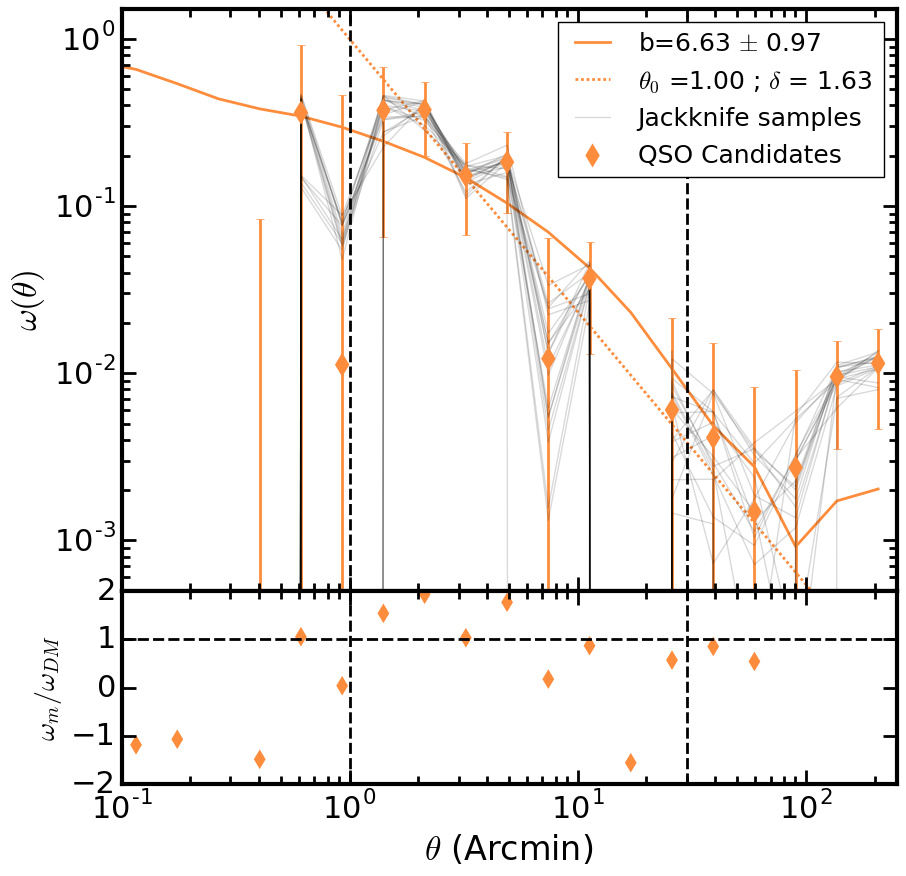

In [87]:
from matplotlib import gridspec
params = {'legend.fontsize': 16, 'xtick.labelsize': 22, 'ytick.labelsize': 22, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':10, 'xtick.minor.size':6, 'ytick.major.size':10, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

#Plot for paper
fig = plt.figure(3,figsize = (10,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.75,0.25])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)

plt.axes(ax0)
plt.scatter(separation[0],wnames[0],s = 150,color='#fd8d3c', marker = 'd',edgecolor='None',label=r'QSO Candidates',zorder = 100)
plt.errorbar(separation[0],wnames[0],yerr=sigma[0]**0.5,elinewidth=2,fmt=',',color='#fd8d3c')

#No Stellar contamination in fit
#plt.plot(separation[0],La,linestyle = '--', dashes = (8,3,8,3),linewidth = 2,color = '#fd8d3c',label='DM model b=%0.2f'%allzbias[0])

#With Stellar contamination in fit
plt.plot(separation[0],Las,linewidth = 2,color = '#fd8d3c',label = r'b=%0.2f $\pm$ %0.2f'%(allzb[0],allzcov[0][0]))

#Power law fit
plt.plot(separation[0],allpow,color='#fd8d3c',linewidth = 2, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(apfit[0],apfit[1]))

for i in range(len(JK_xi[0])): 
    if i == len(JK_xi[0])-1:
        plt.plot(separation[0],JK_xi[0][i],color='k',alpha = 0.15, linewidth = 1,label='Jackknife samples')
    else:
        #plt.scatter(separation[0],JK_xi[0][i],s = 15,color='k',alpha = 0.5, marker = 's',edgecolor='None')
        plt.plot(separation[0],JK_xi[0][i],color='k',alpha = 0.15, linewidth = 1)

        ax0.set_ylim(5e-4,1.5)

ax0.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.set_yscale('log')
ax0.set_ylabel(r'$\omega (\theta)$',fontsize = 24)
ax0.legend(fontsize = 18, scatterpoints=1)

plt.axes(ax1)
plt.axhline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.scatter(separation[0],np.asarray(wnames[0])/Las,s = 100,color='#fd8d3c', marker = 'd',edgecolor='None' )
ax1.yaxis.set_ticks([-2,-1,0,1,2])
ax1.set_ylabel(r'$\omega_m / \omega_{DM}$', fontsize = 20)

plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.xlim(0.1,250)
plt.ylim(-2,2)
plt.xscale('log')
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 24)

#plt.savefig('./SpIES_corrfunc_only.pdf',bbox_inches='tight')

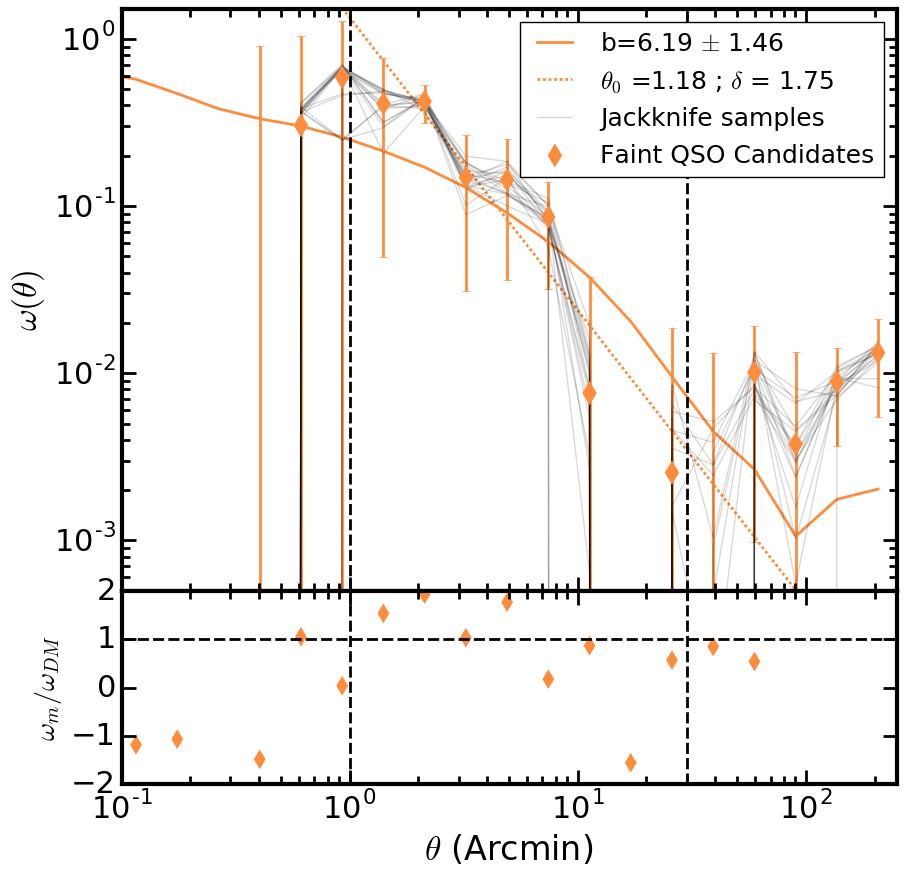

In [88]:
from matplotlib import gridspec
params = {'legend.fontsize': 16, 'xtick.labelsize': 22, 'ytick.labelsize': 22, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':10, 'xtick.minor.size':6, 'ytick.major.size':10, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

#Plot for paper
fig = plt.figure(3,figsize = (10,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.75,0.25])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)

plt.axes(ax0)
plt.scatter(separation[0],wnames[1],s = 150,color='#fd8d3c', marker = 'd',edgecolor='None',label=r'Faint QSO Candidates',zorder = 100)
plt.errorbar(separation[0],wnames[1],yerr=sigma[1]**0.5,elinewidth=2,fmt=',',color='#fd8d3c')

#No Stellar contamination in fit
#plt.plot(separation[0],La,linestyle = '--', dashes = (8,3,8,3),linewidth = 2,color = '#fd8d3c',label='DM model b=%0.2f'%allzbias[0])

#With Stellar contamination in fit
plt.plot(separation[0],Lls,linewidth = 2,color = '#fd8d3c',label = r'b=%0.2f $\pm$ %0.2f'%(lowzb[0],lowzcov[0][0]))

#Power law fit
plt.plot(separation[0],lowpow,color='#fd8d3c',linewidth = 2, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(lpfit[0],lpfit[1]))

for i in range(len(JK_xi[0])): 
    if i == len(JK_xi[0])-1:
        plt.plot(separation[0],JK_xi[1][i],color='k',alpha = 0.15, linewidth = 1,label='Jackknife samples')
    else:
        #plt.scatter(separation[0],JK_xi[0][i],s = 15,color='k',alpha = 0.5, marker = 's',edgecolor='None')
        plt.plot(separation[0],JK_xi[1][i],color='k',alpha = 0.15, linewidth = 1)

        ax0.set_ylim(5e-4,1.5)

ax0.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.set_yscale('log')
ax0.set_ylabel(r'$\omega (\theta)$',fontsize = 24)
ax0.legend(fontsize = 18, scatterpoints=1)

plt.axes(ax1)
plt.axhline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.scatter(separation[0],np.asarray(wnames[0])/Las,s = 100,color='#fd8d3c', marker = 'd',edgecolor='None' )
ax1.yaxis.set_ticks([-2,-1,0,1,2])
ax1.set_ylabel(r'$\omega_m / \omega_{DM}$', fontsize = 20)

plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.xlim(0.1,250)
plt.ylim(-2,2)
plt.xscale('log')
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 24)

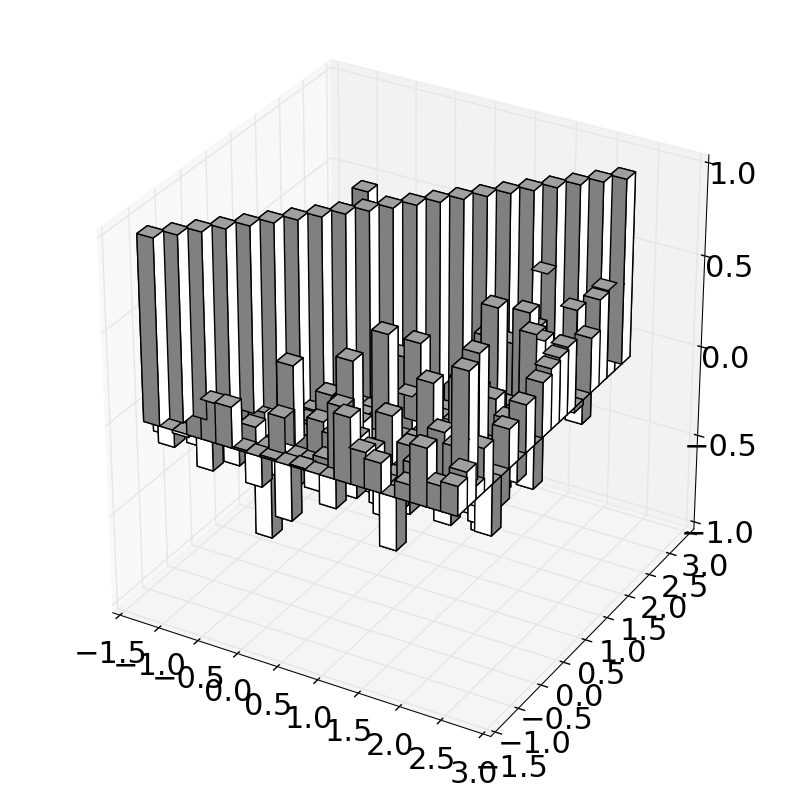

In [89]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(6,figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

# Construct arrays for the anchor positions of the 16 bars.
# Note: np.meshgrid gives arrays in (ny, nx) so we use 'F' to flatten xpos,
# ypos in column-major order. For numpy >= 1.7, we could instead call meshgrid
# with indexing='ij'.
X,Y = np.meshgrid(np.log10(th),np.log10(th))
xpos = X.flatten('F')
ypos = Y.flatten('F')
zpos = np.zeros_like(xpos)

# Construct arrays with the dimensions for the 16 bars.
dx = 0.2*np.ones_like(zpos)
dy = dx.copy()
dz = regmat[0].flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='w', zsort='average')
ax.set_zlim(-1,1)

plt.show()

In [90]:
#JT REG MAT

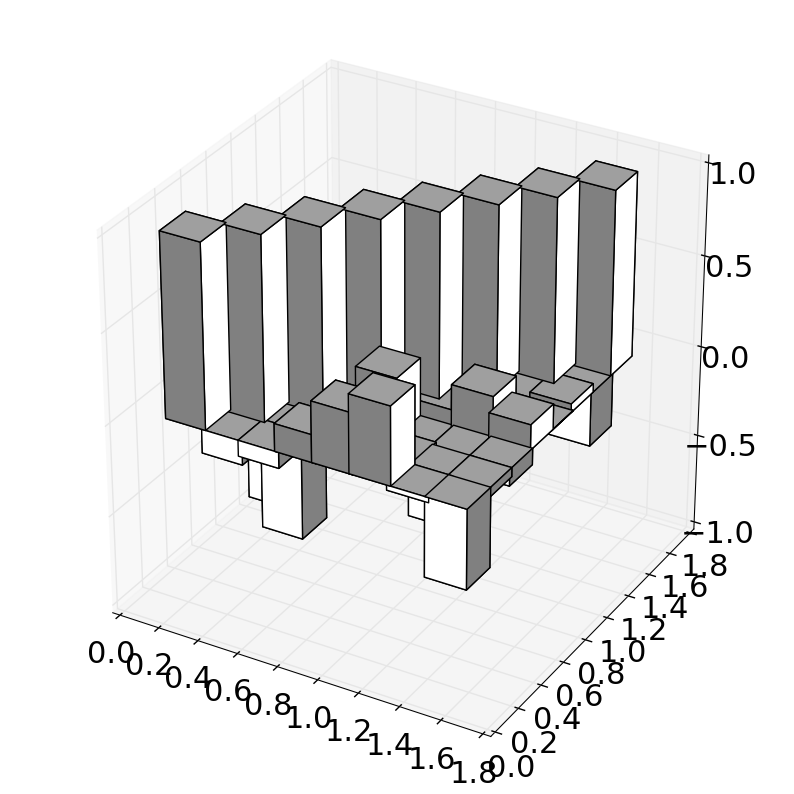

In [91]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

bdx = (np.asarray(separation[0])>1) & (np.asarray(separation[0])<30) 

fig = plt.figure(6,figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

# Construct arrays for the anchor positions of the 16 bars.
# Note: np.meshgrid gives arrays in (ny, nx) so we use 'F' to flatten xpos,
# ypos in column-major order. For numpy >= 1.7, we could instead call meshgrid
# with indexing='ij'.
X,Y = np.meshgrid(np.log10(np.asarray(separation[0])[bdx]),np.log10(np.asarray(separation[0])[bdx]))
xpos = X.flatten('F')
ypos = Y.flatten('F')
zpos = np.zeros_like(xpos)

# Construct arrays with the dimensions for the 16 bars.
dx = 0.2*np.ones_like(zpos)
dy = dx.copy()
dz = regmat[0][:,bdx][bdx,:].flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='w', zsort='average')
ax.set_zlim(-1,1)

plt.show()

In [92]:
#Biases from different surveys
### He 2017
bhe = 5.93
behe= 1.43
zhe = 3.8

### ROSS 2009
b = [2.06,1.41,1.38,1.45,1.83,2.37,1.92,2.42,2.79,3.62,2.99]
be = [0.03,0.18,0.06,0.38,0.33,0.25,0.5,0.4,0.47,0.49,1.42]
z = [1.27,0.24,0.49,0.80,1.03,1.23,1.41,1.58,1.74,1.92,2.10]

##SHEN 2007 Biases
#sb = [9.8,11.4,13.7]
#sz = [3,3.5,4]
sb = [7.9,14.2]
sbe = [0.8,1.4]
sz = [3,4]

### EFTEKHARZADEH
eb = [3.69,3.55,3.57]
ebe = [0.11,0.15,0.09]
ez = [2.297,2.497,2.971]

#### HOPKINS 2007 MODELS

maxdatH07 = open('./Hopkins07_clstr_maximal.dat','rw')
defdatH07 = open('./Hopkins07_clstr_default.dat','rw')
extdatH07 = open('./Hopkins07_clstr_extreme_feedback.dat','rw')

maxH07 = maxdatH07.readlines()
defH07 = defdatH07.readlines()
extH07 = extdatH07.readlines()


zH07 = []
bmH07 = []
bdH07 = []
beH07 = []

b20mH07 = []
b20eH07 = []
b20dH07 = []

for i in range(len(maxH07)):
    valm=maxH07[i].split()
    vald=defH07[i].split()
    vale=extH07[i].split()
    zH07.append(np.float(valm[0]))
    bmH07.append(np.float(valm[1]))
    bdH07.append(np.float(vald[1]))
    beH07.append(np.float(vale[1]))
    b20mH07.append(np.float(valm[3]))
    b20eH07.append(np.float(vale[3]))
    b20dH07.append(np.float(vald[3]))
    


6.63367982454 0.971098273316


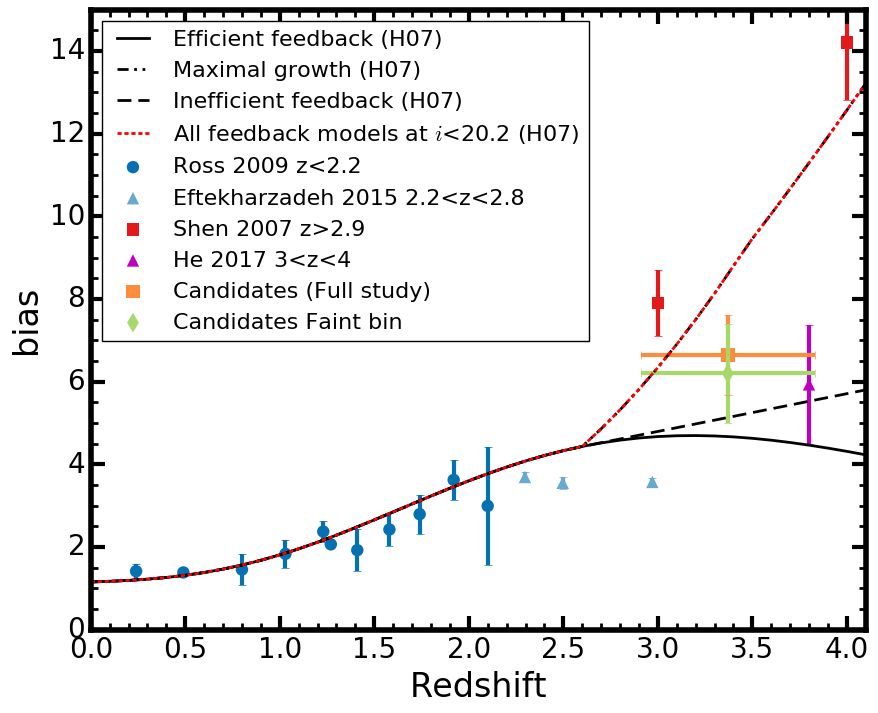

In [93]:
params = {'legend.fontsize': 16, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'xtick.major.width':3, 'xtick.minor.width':2, 'ytick.major.width':3, 'ytick.minor.width':2, 'xtick.major.size':10, 'xtick.minor.size':5, 'ytick.major.size':10, 'ytick.minor.size':5}
plt.rcParams.update(params)
plt.rc("axes", linewidth=4.0)

plt.figure(5,figsize=(10,8))
#ax1 = fig.add_subplot(1,1,1)

plt.scatter(z,b,s=80,c='#0571b0', marker = 'o', edgecolor = 'none', label='Ross 2009 z<2.2')
plt.errorbar(z,b,yerr=be,color='#0571b0', fmt=',',linewidth=3)

plt.scatter(ez,eb,s=80,c='#67a9cf', marker = '^',edgecolor = 'none', label='Eftekharzadeh 2015 2.2<z<2.8')
plt.errorbar(ez,eb,yerr=ebe,color='#67a9cf', fmt=',',linewidth=3)

plt.scatter(sz,sb,s=80,c='#e31a1c', marker = 's',edgecolor = 'none', label='Shen 2007 z>2.9')
plt.errorbar(sz,sb,yerr=sbe,color='#e31a1c', fmt=',',linewidth=3)

plt.scatter(zhe,bhe,s=80,c='m', marker = '^',edgecolor = 'none', label='He 2017 3<z<4')
plt.errorbar(zhe,bhe,yerr=behe,color='m', fmt=',',linewidth=3)

'''
#No stellar contam
plt.scatter(3.479,allzbias, marker = 'd',c='#ca0020', s=100, edgecolor = 'none', label = 'Candidates')
plt.errorbar(3.479,allzbias,yerr=0.22878057**0.5,color='#ca0020', fmt=',',linewidth=3)

plt.scatter(3.143,lowzbias, marker = 'd',c='#ca0020', s=100, edgecolor = 'none')
plt.errorbar(3.143,lowzbias,yerr=0.60656223**0.5,color='#ca0020', fmt=',',linewidth=3)

plt.scatter(3.803,highzbias, marker = 'd',c='#ca0020', s=100, edgecolor = 'none')
plt.errorbar(3.803,highzbias,yerr=0.50286617**0.5,color='#ca0020', fmt=',',linewidth=3)
'''
print allzb[0],allzcov[0][0]
#Stellar contam
plt.scatter(3.37,allzb[0], marker = 's',c='#fd8d3c', s=100, edgecolor = 'none', label = 'Candidates (Full study)')
plt.errorbar(3.37,allzb[0],xerr= 0.46, yerr=allzcov[0][0],color='#fd8d3c', fmt=',',linewidth=3)

plt.scatter(3.37,lowzb[0], marker = 'd',c='#a6d96a', s=100, edgecolor = 'none', label = 'Candidates Faint bin')
plt.errorbar(3.37,lowzb[0],xerr=0.46 ,yerr=lowzcov[0][0]**0.5,color='#a6d96a', fmt=',',linewidth=3)
'''
plt.scatter(3.803,highzb[0], marker = 'd',c='#1a9641', s=100, edgecolor = 'none', label = 'Candidates High-z bin')
plt.errorbar(3.803,highzb[0],xerr=0.31 , yerr=highzcov[0][0]**0.5,color='#1a9641', fmt=',',linewidth=3)
'''
#plt.plot(zH07,b20mH07, linewidth = 2, linestyle='-', color='c',label = "i < 20.2 degeneracy")
plt.plot(zH07,beH07, linewidth = 2, linestyle='-', color='k',label = "Efficient feedback (H07)")
plt.plot(zH07,bmH07, linewidth = 2, linestyle='-.', color='k',dashes = (8,4,2,4,2,4), label = "Maximal growth (H07)")
plt.plot(zH07,bdH07, linewidth = 2, linestyle='--', dashes = (10,5,10,5), color='k',label = "Inefficient feedback (H07)")

plt.plot(zH07,b20mH07, linewidth = 2, linestyle=':', c='r',dashes = (3,2,3,2), label = r"All feedback models at $i$<20.2 (H07)")
#plt.plot(zH07,b20eH07, linewidth = 2, linestyle=':', c='r',dashes = (3,2,3,2), label = r"$i$=20.2 (H07)")
#plt.plot(zH07,b20dH07, linewidth = 2, linestyle=':', c='b',dashes = (3,2,3,2), label = r"Feedback models with $i$=20.2 (H07)")

plt.xlabel('Redshift',fontsize = 24)
plt.ylabel('bias',fontsize = 24)
plt.ylim(0,15)
plt.xlim(0,4.1)
plt.legend(loc = 2, scatterpoints=1)
plt.minorticks_on()
#plt.savefig('./Bais_v_Redshift_paper.pdf')
plt.show()